In [1]:
%matplotlib inline

# Imports
import gc
import matplotlib.pyplot as plt
import os
import statsmodels.stats.proportion
import sklearn.pipeline
import pandas as pd

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [2]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

if os.path.exists("../data/output/feature_data.hdf.gz"):
    print("Loading from HDF5 cache")
    feature_df = pandas.read_hdf("../data/output/feature_data.hdf.gz", "root")
    
    # Write out feature datas
    #feature_df.to_hdf("../data/output/feature_data.hdf.gz", "root", complevel=6, complib="zlib")

# Process
#feature_df = preprocess_raw_data(raw_data, include_direction=True)

# Write out feature datas
#feature_df.to_hdf("../data/output/feature_data.hdf.gz", "root", complevel=6, complib="zlib")

Loading from HDF5 cache


In [3]:
# Downsample to float
feature_df = feature_df.astype(numpy.float16)

# Remove term
nonterm_features = [f for f in feature_df.columns if not f.startswith("term_")]
original_feature_df = feature_df.copy()
feature_df = original_feature_df.loc[:, nonterm_features].copy()
gc.collect()

5593

In [4]:
# Reset output file timestamp per run
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Reset seed per run
numpy.random.seed(0)

# Setup training time period
dummy_window = 10
min_training_years = 25

term_range = range(raw_data["term"].max() - 4,
                   raw_data["term"].max() + 1)
#term_range = range(raw_data["term"].min() + min_training_years,
                   #raw_data["term"].max() + 1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 5

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Setup model
m = None
term_count = 0
feature_importance_df = pandas.DataFrame()

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    dummy_train_index = ((raw_data.loc[:, "term"] < term) & (raw_data.loc[:, "term"] >= (term-dummy_window))).values
    test_index = (raw_data.loc[:, "term"] == term).values
    if test_index.sum() == 0:
        continue
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = (raw_data.loc[train_index, "justice_outcome_disposition"]).astype(int)
    target_data_weights = target_data_train.value_counts() / target_data_train.shape[0]
    
    # Get sample weights: create a new dataframe by merging target_data_weights with target_data_train then exporting to list
    target_data_sample_ws = target_data_train.map(target_data_weights)

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = (raw_data.loc[test_index, "justice_outcome_disposition"]).astype(int)
    
    # Check if the justice set has changed
    if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "naturalCourt"].unique()) != \
        set(raw_data.loc[raw_data.loc[:, "term"] == (term), "naturalCourt"].unique()):
        # natural Court change; trigger forest fire
        print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None

    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        rf = sklearn.ensemble.GradientBoostingClassifier(n_estimators=initial_trees + (term_count * trees_per_term),
                                                     #class_weight=target_data_weights.to_dict(),
                                                    warm_start=True)
        m = rf
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train, sample_weight=target_data_sample_ws)
    #print(m.get_params())
    
    # Record feature weights
    current_feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.feature_importances_)),
                                         columns=["feature", "importance"])
    current_feature_importance_df.loc[:, "term"] = term
    if feature_importance_df.shape[0] == 0:
        feature_importance_df = current_feature_importance_df.copy()
    else:
        feature_importance_df = feature_importance_df.append(current_feature_importance_df.copy())

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_df.loc[dummy_train_index, :],
          (raw_data.loc[dummy_train_index, "justice_outcome_disposition"]).astype(int))
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)
    
    #  Clear
    del feature_data_train
    del feature_data_test
    del target_data_train
    del target_data_test
    gc.collect()

Term: 2010
Natural court change; rebuilding with 130 trees
Term: 2011
Term: 2012
Term: 2013
Term: 2014


In [5]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(m, open(filename, 'wb'))

# Evaluate Performance of Model vs. a Smart, In-Sample Baseline

In [6]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"].astype(int)
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"].astype(int)
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Setup reverse testing
reverse_target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
reverse_target_predicted = (raw_data.loc[evaluation_index, "rf_predicted"] > 0).astype(int)
reverse_target_dummy = (raw_data.loc[evaluation_index, "dummy_predicted"] > 0).astype(int)
raw_data.loc[:, "rf_reverse_correct"] = numpy.nan
raw_data.loc[:, "dummy_reverse_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_reverse_correct"] = (reverse_target_actual == reverse_target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_reverse_correct"] = (reverse_target_actual == reverse_target_dummy).astype(float)

In [7]:
# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       1.00      0.26      0.41       141
          0       0.45      0.30      0.36      1172
          1       0.66      0.81      0.73      2170

avg / total       0.60      0.62      0.59      3483

[[  36   18   87]
 [   0  346  826]
 [   0  408 1762]]
0.615561297732

Dummy model
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00       141
          0       0.00      0.00      0.00      1172
          1       0.62      1.00      0.77      2170

avg / total       0.39      0.62      0.48      3483

[[   0    0  141]
 [   0    0 1172]
 [   0    0 2170]]
0.623026126902



/Users/philiplockwood-bean/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(reverse_target_actual, reverse_target_predicted))
print(sklearn.metrics.confusion_matrix(reverse_target_actual, reverse_target_predicted))
print(sklearn.metrics.accuracy_score(reverse_target_actual, reverse_target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(reverse_target_actual, reverse_target_dummy))
print(sklearn.metrics.confusion_matrix(reverse_target_actual, reverse_target_dummy))
print(sklearn.metrics.accuracy_score(reverse_target_actual, reverse_target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

          0       0.50      0.30      0.38      1313
          1       0.66      0.81      0.73      2170

avg / total       0.60      0.62      0.60      3483

[[ 400  913]
 [ 408 1762]]
0.620729256388

Dummy model
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1313
          1       0.62      1.00      0.77      2170

avg / total       0.39      0.62      0.48      3483

[[   0 1313]
 [   0 2170]]
0.623026126902



/Users/philiplockwood-bean/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Investigate Feature Importances of Last Version of the Model

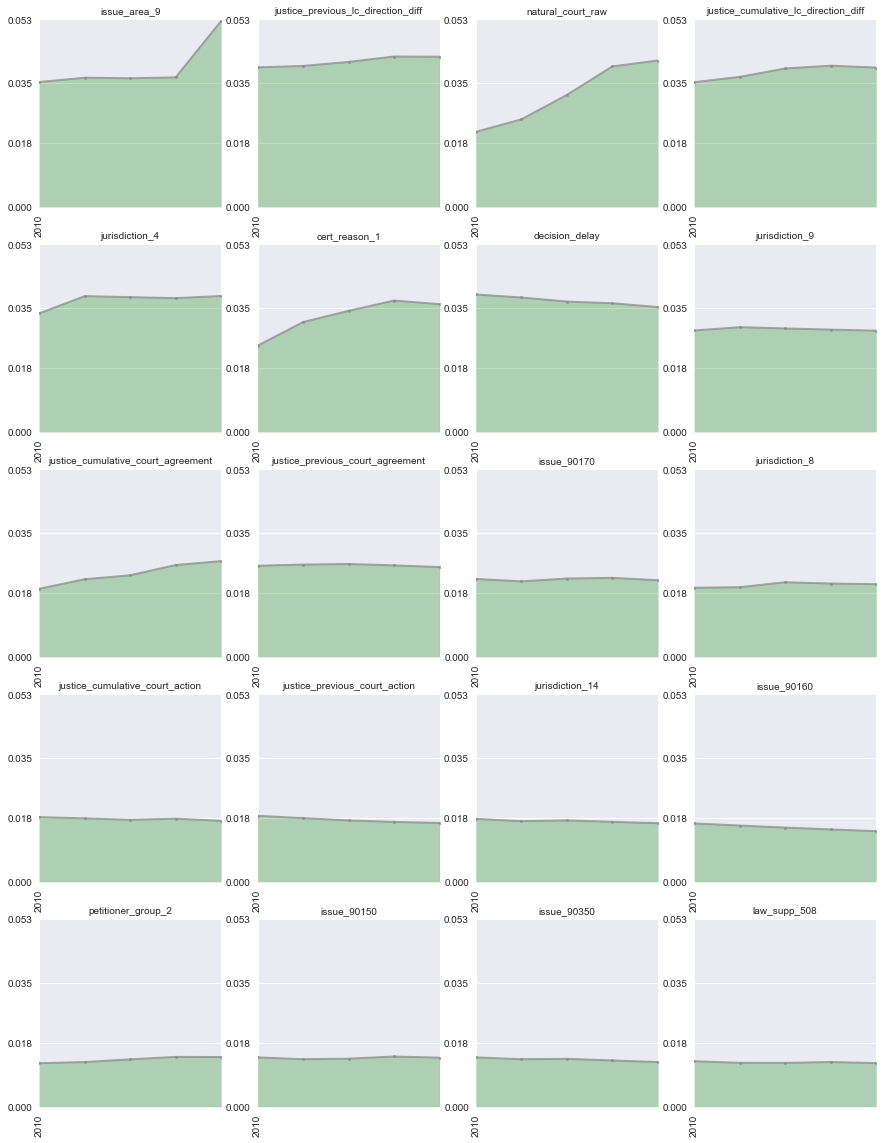

In [9]:
# Setup feature importance TS
feature_importance_ts = feature_importance_df.groupby(["term", "feature"])["importance"].mean().unstack()

# Get last step weights
num_feature_rows = 5
num_feature_cols = 4
num_feature_total = num_feature_rows * num_feature_cols
last_step = feature_importance_ts.tail(1).T
last_step_top_features = last_step.sort_values(last_step.columns[0], ascending=False).head(num_feature_total).index.tolist()

# Get axis data
min_term = feature_importance_df["term"].min()
max_term = feature_importance_df["term"].max()
min_val = feature_importance_df["importance"].min()
max_val = feature_importance_df["importance"].max()

# Setup grid
#f = plt.figure(figsize=(16, 16))
f, ax = plt.subplots(num_feature_rows, num_feature_cols, figsize=(15,20))

for i in range(len(last_step_top_features)):
    # Get iteration indices
    row_id = int(i / num_feature_cols)
    col_id = (i % num_feature_cols)
    feature_name = last_step_top_features[i]
    
    # Setup title and data
    ax[row_id, col_id].set_title("{0}".format(feature_name), fontsize=10)
    ts_data = feature_importance_ts.loc[:, feature_name]
    
    # Plot fill and marker
    ax[row_id, col_id].fill_between(ts_data.index, 0, ts_data, alpha=0.25, color="green")
    ax[row_id, col_id].plot(ts_data.index, ts_data, marker="o", markersize=3, linewidth=2, color="#898989", alpha=0.75)
    
    # Setup axes
    ax[row_id, col_id].set_xlim(min_term, max_term)
    ax[row_id, col_id].set_xticks(numpy.arange(min_term, max_term, 10))
    ax[row_id, col_id].set_xticklabels(map(str, numpy.arange(min_term, max_term, 10)), rotation=90)
    ax[row_id, col_id].set_ylim(min_val, max_val)
    ax[row_id, col_id].set_yticks(numpy.round(numpy.linspace(min_val, max_val, 4), 3))

# Feature Engineering and Partial Dependence

### Feature Interaction Engineering

In [184]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
import numpy as np
regression = LinearRegression(normalize=True)
crossvalidation = KFold(n=feature_df.shape[0], n_folds=10, shuffle=True, random_state=1)

In [80]:
last_step2 = pd.DataFrame(m.feature_importances_)

In [156]:
last_step_top_features = last_step2.sort_values(last_step2.columns[0], ascending=False).head(10)

In [157]:
top_feats = last_step_top_features.index

In [159]:
feat_labels = []
for i, name in enumerate(feature_df.columns):
    if i in top_feats:
        feat_labels.append(name)

In [160]:
feats_ix

['natural_court_raw',
 'decision_delay',
 'jurisdiction_4',
 'jurisdiction_8',
 'jurisdiction_9',
 'jurisdiction_14',
 'cert_reason_1',
 'issue_90170',
 'issue_area_9',
 'justice_previous_court_action',
 'justice_cumulative_court_action',
 'justice_previous_court_agreement',
 'justice_cumulative_court_agreement',
 'justice_previous_lc_direction_diff',
 'justice_cumulative_lc_direction_diff']

In [185]:
y = raw_data.loc[:, "justice_outcome_disposition"].astype(int)

In [163]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [164]:
feats_ix[:5]

['natural_court_raw',
 'decision_delay',
 'jurisdiction_4',
 'jurisdiction_8',
 'jurisdiction_9']

In [165]:
feats_test = ['decision_delay', 'justice_previous_lc_direction_diff']

In [137]:
plt.rcParams['figure.figsize'] = 20,16

In [169]:
y.value_counts()

 1    2170
 0    1172
-1     141
Name: justice_outcome_disposition, dtype: int64

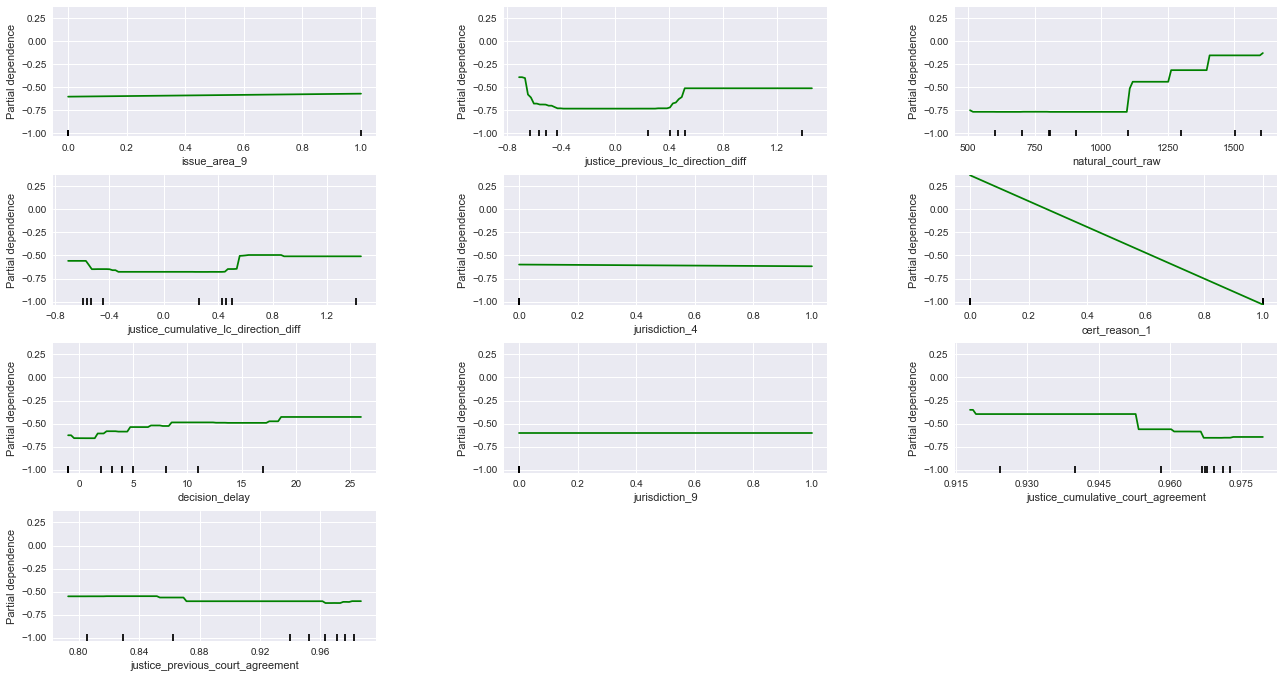

In [170]:
fig2, ax2 = plot_partial_dependence(m, features=top_feats, # column numbers of plots we want to show
                                   X=feature_df,            # raw predictors data.
                                   feature_names=all_labels,# labels on graphs
                                   label=1) # When multi-class GBM, need to specify which outcome label to plot on
                                   #grid_resolution=10) # number of values to plot on x axis

In [182]:
feature_df.columns[131]

'decision_delay'

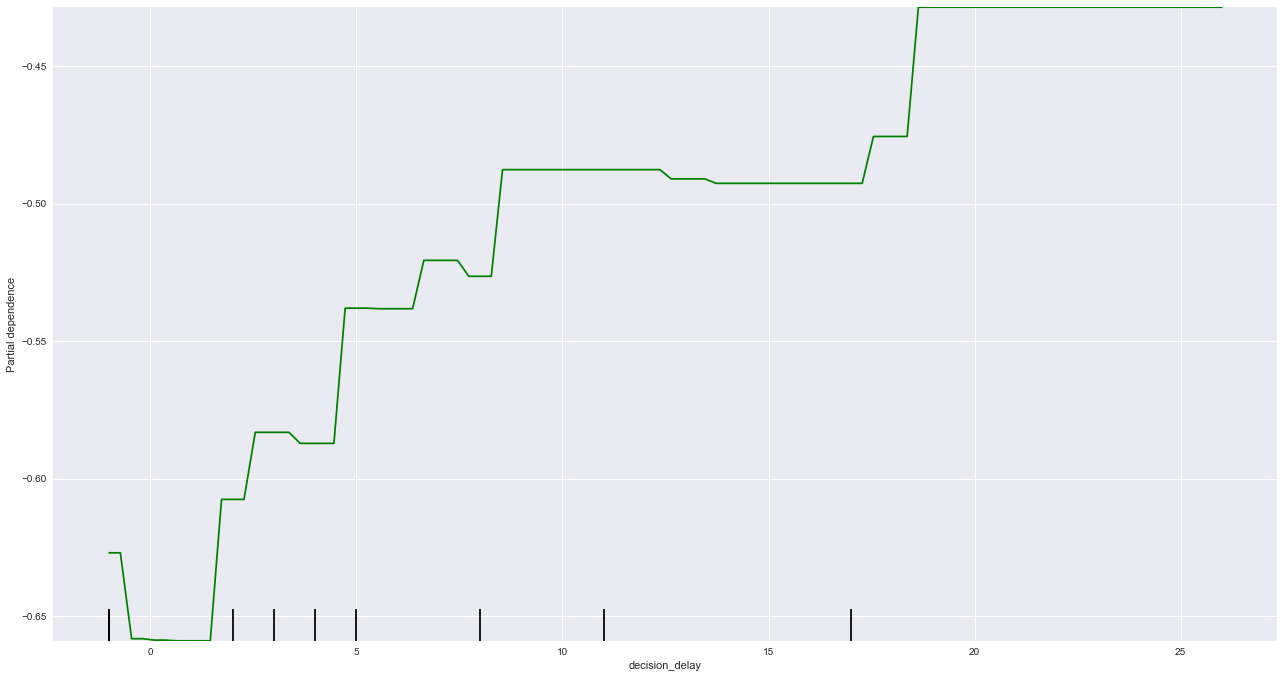

In [183]:
fig2, ax2 = plot_partial_dependence(m, features=[131], # column numbers of plots we want to show
                                   X=feature_df,            # raw predictors data.
                                   feature_names=all_labels,# labels on graphs
                                   label=1) # When multi-class GBM, need to specify which outcome label to plot on
                                    # This label represents predicting a reversal
                                   #grid_resolution=10) # number of values to plot on x axis

In [173]:
comb_feats = [1496, 1499, (1496, 1499)]

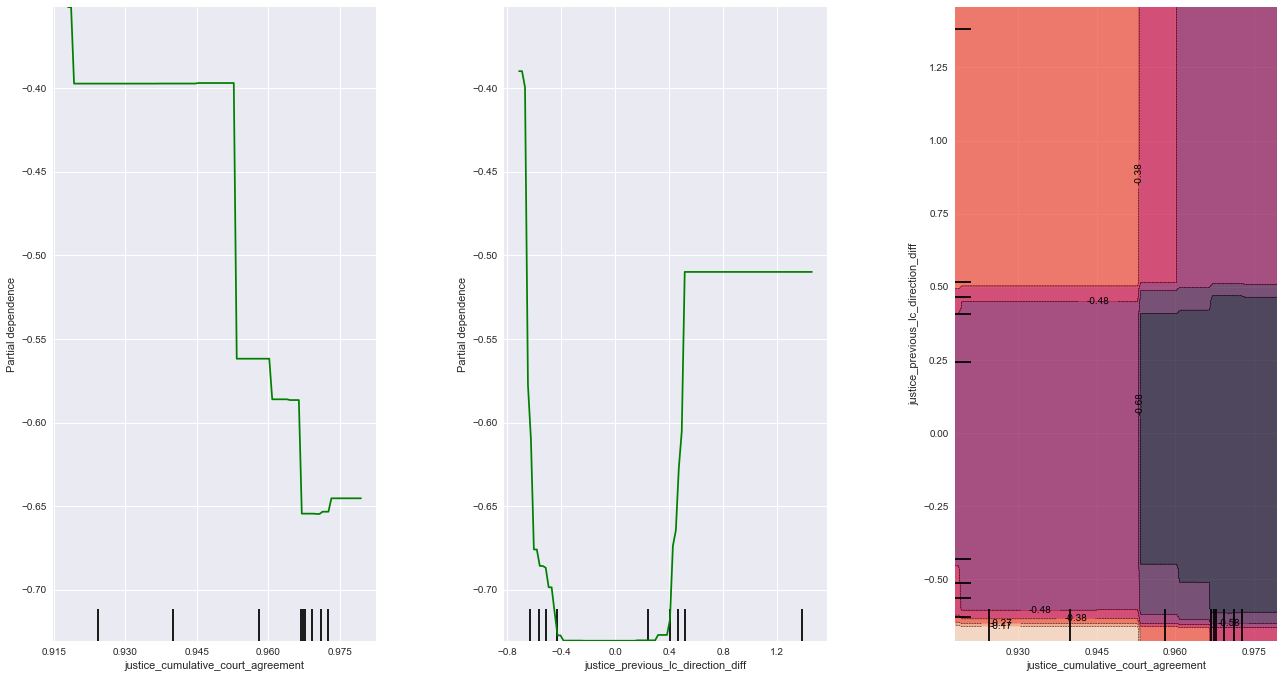

In [174]:
fig2, ax2 = plot_partial_dependence(m, features=comb_feats, # column numbers of plots we want to show
                                   X=feature_df,            # raw predictors data.
                                   feature_names=all_labels,# labels on graphs
                                   label=1) # When multi-class GBM, need to specify which outcome label to plot on
                                    # This label represents predicting a reversal
                                   #grid_resolution=10) # number of values to plot on x axis

Y Axis: The target variable--Supreme Court Decision (-1 is Other, 0 is Affirm, 1 is Reverse, relative to the Lower Court's decision

X Axis: The incremental values in the variable being tested

The plots above show (1): how likely a justice is to agree with the rest of the court, (2): the difference term between the lower court's decision direction and that justice's historic mean direction (aka how far apart the justice is from the lower court, ideologically), and (3): the interaction of the two terms in predicting the outcome

The darker color in the lower right of the combined graph shows that when a justice generally agrees with the court, and is distant from the lower courts, they are more likely to vote to REVERSE the decision